In [ ]:
### Bayesian test for correlation with ZDJ prior

In [1]:
### Imports
import pandas as pd
import xarray as xr
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.integrate import quad
import seaborn as sns

In [2]:
### Color list 
dark_oranges = sns.color_palette("Oranges", n_colors=15)[4:]
dar_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens = sns.color_palette("Greens", n_colors=9)[4:]


In [3]:
path = "/home/jmindlin/BF_codes/data/DCENT_GMST_statistics.txt"

# 1) Find the header line ("Year,GMST (°C),...")
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

start = next(i for i, line in enumerate(lines) if line.strip().startswith("Year,"))

# 2) Read CSV from that header line onward; allow commas with spaces
df = pd.read_csv(
    path,
    skiprows=start,               # start at the header line
    engine="python",
    sep=r"\s*,\s*",               # split on commas, ignoring surrounding spaces
    comment=None
)

# 3) Clean column names to something easy to use
rename_map = {
    "Year": "year",
    "GMST (°C)": "gmst",
    "1 s.d. (°C)": "gmst_sd",
    "GMST non infilled (°C)": "gmst_noninf",
    "1 s.d. (°C; non  infilled)": "gmst_noninf_sd",
}
# in case of double spaces etc., normalize header keys first
df.columns = [re.sub(r"\s+", " ", c).strip() for c in df.columns]
rename_map_norm = {re.sub(r"\s+", " ", k).strip(): v for k, v in rename_map.items()}
df = df.rename(columns=rename_map_norm)

# 4) Ensure numeric dtypes
for c in ["year", "gmst", "gmst_sd", "gmst_noninf", "gmst_noninf_sd"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 5) Convert to xarray (optional)
ds = xr.Dataset(
    {
        "GMST": (["year"], df["gmst"].values),
        "GMST_sd": (["year"], df["gmst_sd"].values),
        "GMST_non_infilled": (["year"], df["gmst_noninf"].values),
        "GMST_non_infilled_sd": (["year"], df["gmst_noninf_sd"].values),
    },
    coords={"year": df["year"].values.astype(int)},
)
ds_full = ds.copy()
# Anomaly relative to 1951–1980
ds = ds - ds.sel(year=slice('1951','1980')).mean(dim='year')

# --- Prep data assumed available: ds with 'year' and 'GMST' ---
t = np.asarray(ds['year'].values).astype(float)
y = ds['GMST'].values.astype(float)

# Focus period (as in your code)
mask_short = (t >= 1950) & (t <= 2022)
t_short = t[mask_short]
y_short = y[mask_short]
n = len(y_short)

# =========================
# Linear model (full period)
# =========================
X_lin = np.column_stack([np.ones(n), t_short])
beta_lin, *_ = np.linalg.lstsq(X_lin, y_short, rcond=None)
yhat_lin = X_lin @ beta_lin
resid_lin = y_short - yhat_lin

# =========================
# ENSO (ONI) loading & annual mean
# =========================
oni_path = '/home/jmindlin/BF_codes/data/oni_data.txt'

def load_oni_xarray(src):
    # Adjust reading logic to your file; this mirrors your approach.
    df_oni = np.loadtxt(src, skiprows=1, max_rows=76)
    oni = np.concatenate([df_oni[i, 1:13].flatten() for i in range(df_oni.shape[0]-1)])
    t_monthly = pd.date_range('1950-01-01', '2025-01-01', freq='ME')
    da = xr.DataArray(
        oni, dims=["time"], coords={"time": t_monthly}, name="oni",
        attrs={"units": "degC", "source": "NOAA"}
    )
    return da

oni = load_oni_xarray(oni_path)
oni_annual = oni.groupby('time.year').mean(dim='time')  # annual mean 1950–2024
oni_years = oni_annual['year'].values.astype(int)
oni_vals = oni_annual.values

# =========================
# Quadratic detrending (1950–2024)
# =========================
X_quad = np.column_stack([np.ones(len(t_short)), t_short, t_short**2])
beta_quad, *_ = np.linalg.lstsq(X_quad, y_short, rcond=None)
yhat_quad_shortPeriod = X_quad @ beta_quad
resid_quad_shortPeriod = y_short - yhat_quad_shortPeriod

# =========================
# Align ONI to years of GMST residuals
# =========================
t_enso_years = t_short.astype(int)
oni_map = {int(yy): float(val) for yy, val in zip(oni_years, oni_vals)}
oni_aligned = np.array([oni_map.get(int(yy), np.nan) for yy in t_enso_years], dtype=float)

valid = ~np.isnan(oni_aligned)
t_enso = t_short[valid]
y_enso = resid_quad_shortPeriod[valid]
oni_aligned = oni_aligned[valid]
n = len(y_enso)

# =========================
# Diagnostics / statistics
# =========================
# Pearson correlation and p-value (two-sided)
from scipy.stats import pearsonr, t as student_t
r, p = pearsonr(y_enso, oni_aligned)

# R^2 from simple regression of residuals on ONI
X_enso = np.column_stack([np.ones(n), oni_aligned])
beta_enso, *_ = np.linalg.lstsq(X_enso, y_enso, rcond=None)
yhat_enso = X_enso @ beta_enso
resid_enso = y_enso - yhat_enso
RSS_enso = np.sum(resid_enso**2)
TSS_enso = np.sum((y_enso - np.mean(y_enso))**2)
R2_enso = 1 - RSS_enso / TSS_enso

# JZS Bayes factor for k=1 predictor using the Wetzels & Wagenmakers setup

def bayes_factor_JZS(n, k, R2):
    """
    JZS Bayes factor for linear regression with k predictors (excluding intercept).
    Mirrors the 1D integral used in Wetzels & Wagenmakers (2012).
    """
    def integrand(g):
        return (1 + g)**((n - k - 1) / 2) * (1 + (1 - R2) * g)**(-(n - 1) / 2) * g**(-3 / 2) * np.exp(-n / (2 * g))
    integral, _ = quad(integrand, 0, np.inf, limit=200)
    # Prefactor; reduces to a simple function of n when k=1
    BF = ((n / 2)**(k / 2) * gamma((k + 1) / 2)) / (np.sqrt(np.pi) * gamma(k / 2)) * integral
    return BF

BF10 = bayes_factor_JZS(n=n, k=1, R2=R2_enso)
BF01 = 1.0 / BF10

# =========================
# Regression coefficient
# ========================
slope_enso = beta_enso[1]
intercept_enso = beta_enso[0]



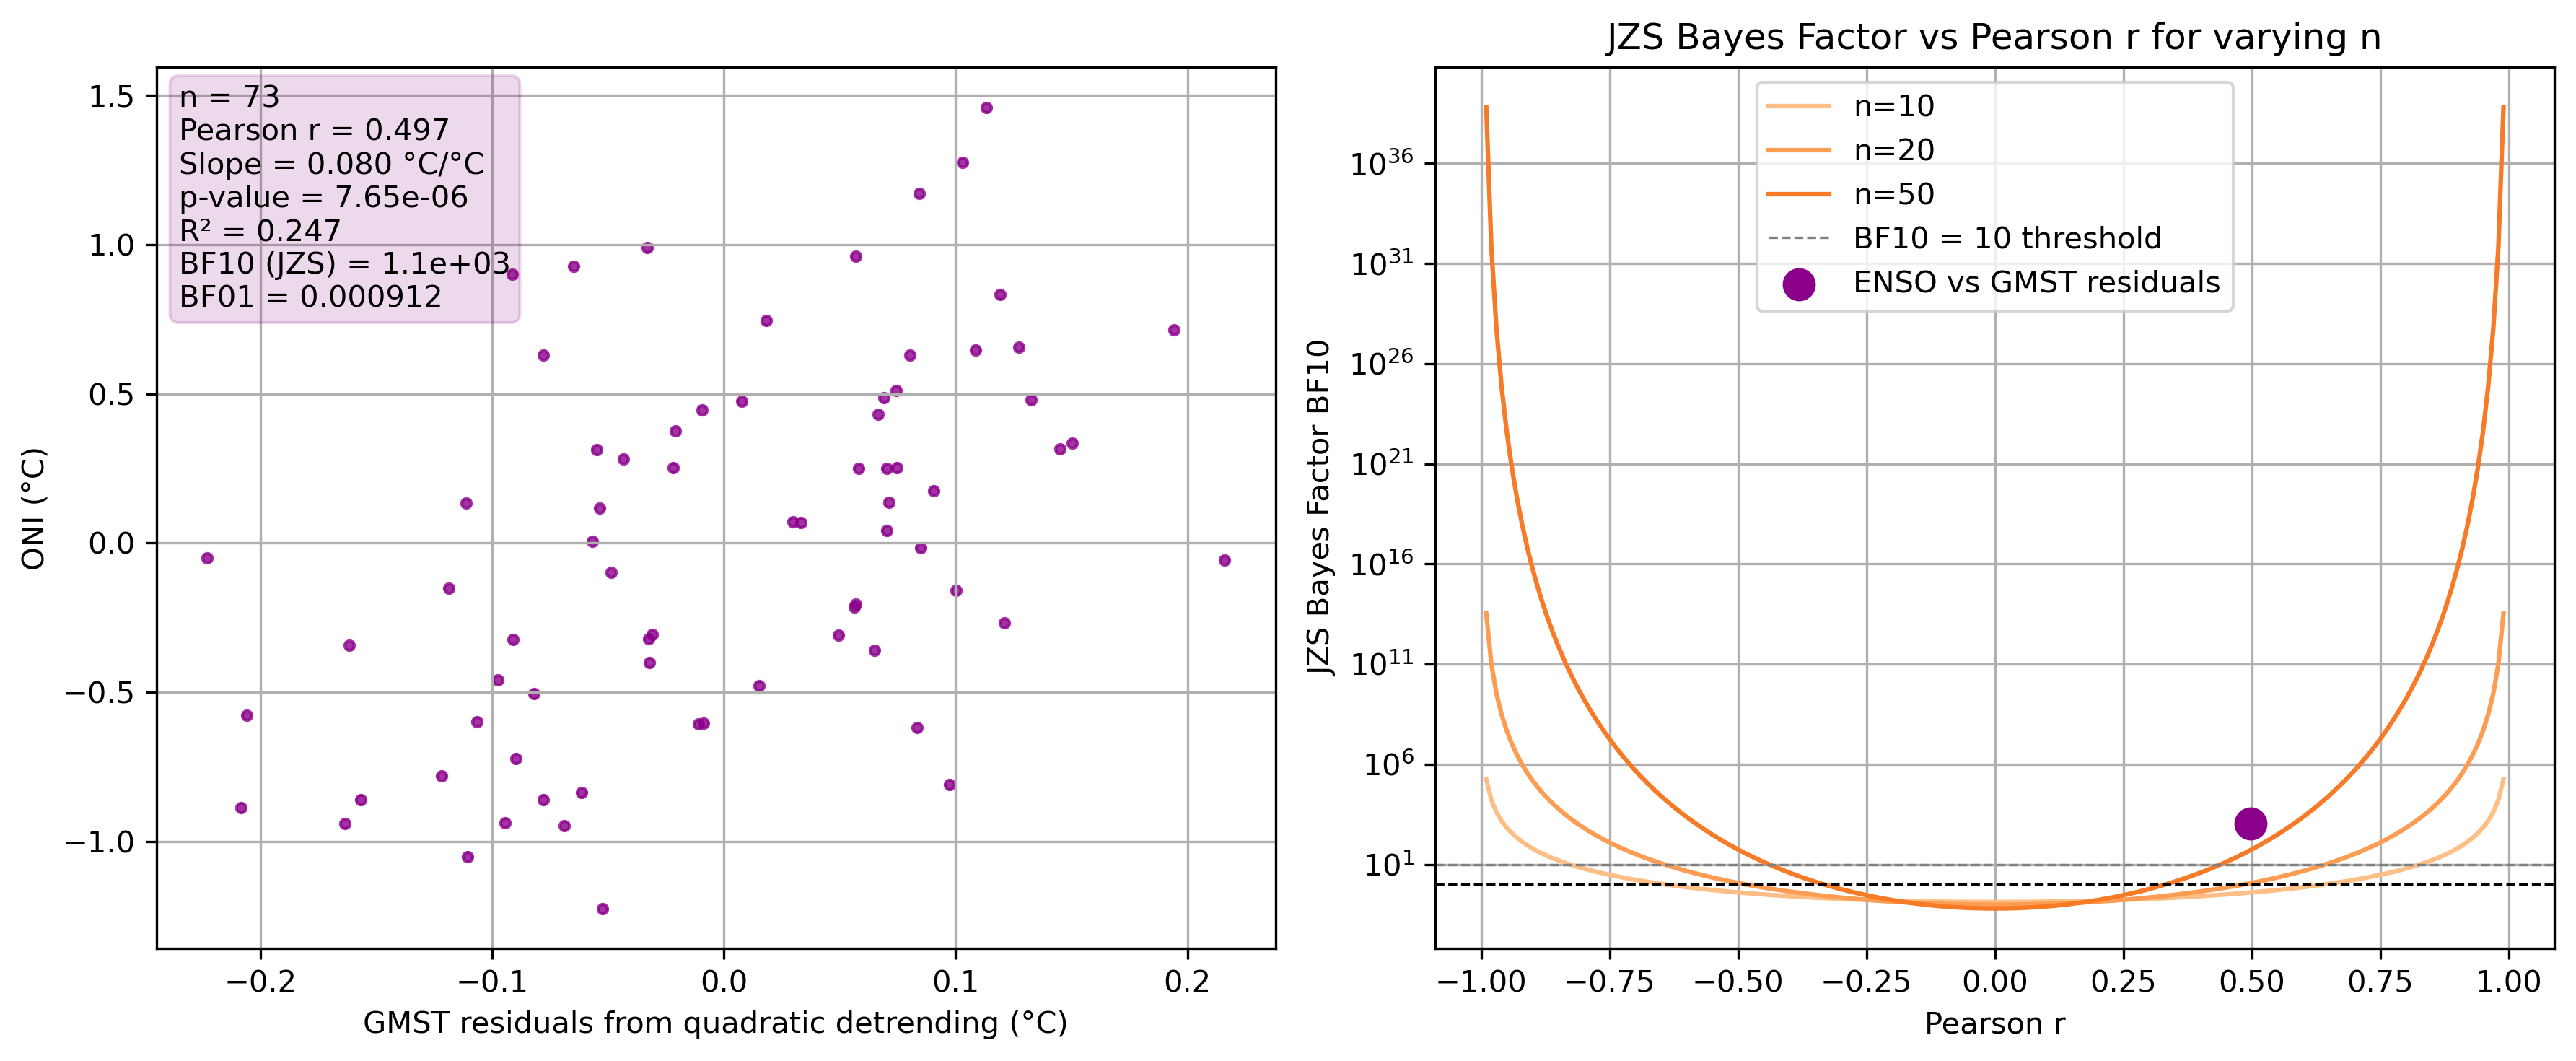

In [4]:

### Plot JZS with varying n
ns = [10, 20, 50]
rs = np.linspace(-0.99, 0.99, 200)

# Text for figure
# Annotation text (top-left)
txt = (
    f"n = {n}\n"
    f"Pearson r = {r:.3f}\n"
    f"Slope = {slope_enso:.3f} °C/°C\n"
    f"p-value = {p:.3g}\n"
    f"R² = {R2_enso:.3f}\n"
    f"BF10 (JZS) = {BF10:.3g}\n"
    f"BF01 = {BF01:.3g}"
)

### Make a joint figure with both plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
# Left: Scatter plot
axs[0].scatter(y_enso, oni_aligned, alpha=0.8, s=10, color='darkmagenta', label='Data points')
axs[0].set_xlabel('GMST residuals from quadratic detrending (°C)')
axs[0].set_ylabel('ONI (°C)')
axs[0].grid(True)
# Annotation text (top-left)
axs[0].text(0.02, 0.98, txt, transform=axs[0].transAxes, va='top', ha='left',
        bbox=dict(boxstyle="round", alpha=0.15,color='purple'))
# Right: JZS BF plot
for i,n_val in enumerate(ns):
    BF_vals = [bayes_factor_JZS(n=n_val, k=1, R2=r_val**2) for r_val in rs]
    axs[1].plot(rs, BF_vals, color=dark_oranges[i*2],label=f'n={n_val}')
axs[1].axhline(10, color='gray', linestyle='--', linewidth=0.8, label='BF10 = 10 threshold')
axs[1].scatter(r, BF10, color='darkmagenta', s=100, zorder=5, label='ENSO vs GMST residuals')
axs[1].set_yscale('log')
axs[1].set_xlabel('Pearson r')
axs[1].set_ylabel('JZS Bayes Factor BF10')
axs[1].set_title('JZS Bayes Factor vs Pearson r for varying n')
axs[1].axhline(1, color='k', linestyle='--', linewidth=0.8)
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()
plt.show()

/tmp/ipykernel_3066275/2179778084.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[0].text(


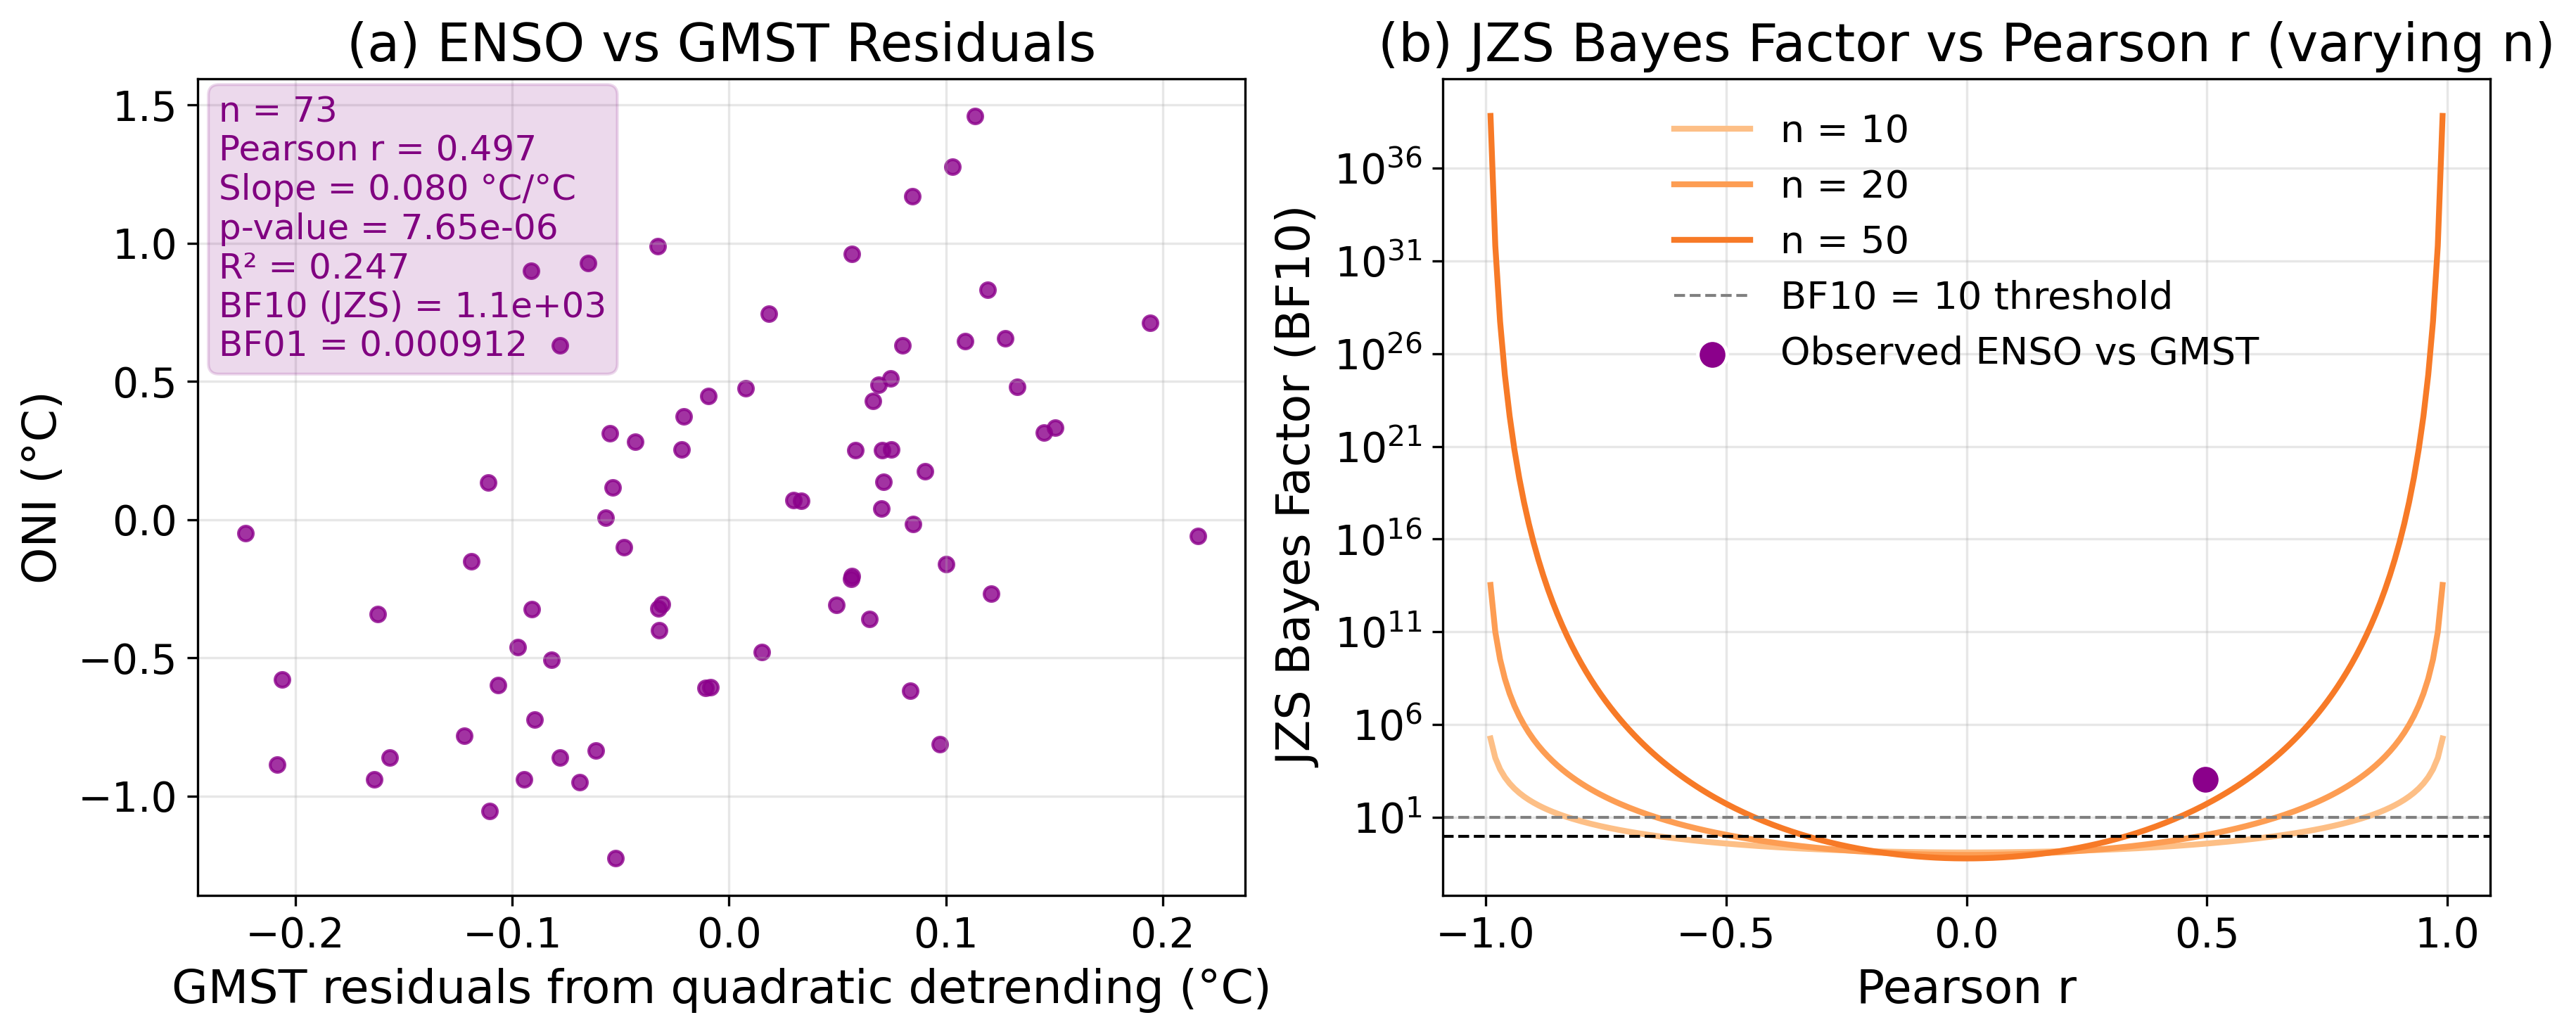

In [5]:
# === FONT SETTINGS ===
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 16
TICK_FONTSIZE  = 14
LEGEND_FONTSIZE = 13
ANNOT_FONTSIZE = 12

# === Data and setup ===
ns = [10, 20, 50]
rs = np.linspace(-0.99, 0.99, 200)

# Example annotation text
txt = (
    f"n = {n}\n"
    f"Pearson r = {r:.3f}\n"
    f"Slope = {slope_enso:.3f} °C/°C\n"
    f"p-value = {p:.3g}\n"
    f"R² = {R2_enso:.3f}\n"
    f"BF10 (JZS) = {BF10:.3g}\n"
    f"BF01 = {BF01:.3g}"
)

# === Figure ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# === Panel (a): Scatter plot ===
axs[0].scatter(y_enso, oni_aligned, alpha=0.8, s=25,
               color='darkmagenta', label='Data points')
axs[0].set_xlabel('GMST residuals from quadratic detrending (°C)', fontsize=LABEL_FONTSIZE)
axs[0].set_ylabel('ONI (°C)', fontsize=LABEL_FONTSIZE)
axs[0].set_title('(a) ENSO vs GMST Residuals', fontsize=TITLE_FONTSIZE)
axs[0].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[0].grid(alpha=0.3)

# Annotation box (top-left)
axs[0].text(
    0.02, 0.98, txt,
    transform=axs[0].transAxes,
    va='top', ha='left',
    fontsize=ANNOT_FONTSIZE,
    color='purple',
    bbox=dict(boxstyle="round", alpha=0.15, color='purple', edgecolor='none')
)

# === Panel (b): JZS Bayes Factor curves ===
for i, n_val in enumerate(ns):
    BF_vals = [bayes_factor_JZS(n=n_val, k=1, R2=r_val**2) for r_val in rs]
    axs[1].plot(rs, BF_vals, color=dark_oranges[i*2], label=f'n = {n_val}', lw=2)

# Add lines and highlight point
axs[1].axhline(10, color='gray', linestyle='--', linewidth=1, label='BF10 = 10 threshold')
axs[1].axhline(1, color='k', linestyle='--', linewidth=1)
axs[1].scatter(r, BF10, color='darkmagenta', s=100, edgecolor='white', linewidth=1.2, zorder=5,
               label='Observed ENSO vs GMST')

# Axes formatting
axs[1].set_yscale('log')
axs[1].set_xlabel('Pearson r', fontsize=LABEL_FONTSIZE)
axs[1].set_ylabel('JZS Bayes Factor (BF10)', fontsize=LABEL_FONTSIZE)
axs[1].set_title('(b) JZS Bayes Factor vs Pearson r (varying n)', fontsize=TITLE_FONTSIZE)
axs[1].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[1].legend(fontsize=LEGEND_FONTSIZE, frameon=False)
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
